# DB2i Agent - LangChain Example

## Architecture

At a high-level, the steps of these systems are:

1. Convert question to SQL query: Model converts user input to a SQL query.
2. Execute SQL query: Execute the query.
3. Answer the question: Model responds to user input using the query results.

## Model

For this demo, we are using `llama3.1` with Ollama


In [35]:
from dotenv import load_dotenv
import os

def load_connection():
    connection_details = {
        "host": os.getenv("HOST"),
        "user": os.getenv("DB_USER"),
        "port": os.getenv("PORT", 8075),
        "password": os.getenv("PASSWORD"),
        "schema": os.getenv("SCHEMA"),
    }
    return connection_details

load_dotenv()
config = load_connection()
SCHEMA = 'SAMPLE'

In [2]:
from tools.database import Db2iDatabase

db = Db2iDatabase(schema=SCHEMA, server_config=config)
print(db.get_usable_table_names())

['ACT', 'AVERAGE_SALARY_PER_DEPARTMENT', 'CL_SCHED', 'DELETEMEPY', 'DEPARTMENT', 'DEPARTMENTS', 'EMPLOYEE', 'EMPLOYEES', 'EMPPROJACT', 'EMP_PHOTO', 'EMP_RESUME', 'IN_TRAY', 'ORG', 'PROJACT', 'PROJECT', 'RANDOMDATA', 'SALES', 'STAFF']


In [3]:
from typing_extensions import TypedDict

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str



In [ ]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1:latest"
)

In [15]:
test_tables = db.get_table_info(['DEPARTMENT', 'EMPLOYEE'])
print(test_tables)

--  Generate SQL
--  Version:                   V7R4M0 190621
--  Generated on:              25/03/10 21:21:01
--  Relational Database:       E7001B91
--  Standards Option:          Db2 for i

CREATE OR REPLACE TABLE SAMPLE.DEPARTMENT (
  DEPTNO CHAR(3) CCSID 273 NOT NULL ,
  DEPTNAME VARCHAR(36) CCSID 273 NOT NULL ,
  MGRNO CHAR(6) CCSID 273 DEFAULT NULL ,
  ADMRDEPT CHAR(3) CCSID 273 NOT NULL ,
  "LOCATION" CHAR(16) CCSID 273 DEFAULT NULL ,
  CONSTRAINT SAMPLE.Q_SAMPLE_DEPARTMENT_DEPTNO_00001 PRIMARY KEY( DEPTNO ) )

  RCDFMT DEPARTMENT ;

ALTER TABLE SAMPLE.DEPARTMENT
  ADD CONSTRAINT SAMPLE.ROD
  FOREIGN KEY( ADMRDEPT )
  REFERENCES SAMPLE.DEPARTMENT ( DEPTNO )
  ON DELETE CASCADE
  ON UPDATE NO ACTION ;

ALTER TABLE SAMPLE.DEPARTMENT
  ADD CONSTRAINT SAMPLE.RDE
  FOREIGN KEY( MGRNO )
  REFERENCES SAMPLE.EMPLOYEE ( EMPNO )
  ON DELETE SET NULL
  ON UPDATE NO ACTION ;
3 sample rows from DEPARTMENT:
DEPTNO	DEPTNAME	MGRNO	ADMRDEPT	LOCATION
A00	SPIFFY COMPUTER SERVICE DIV.	000010	A00	N

In [36]:
from typing_extensions import Annotated
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state):
    """
    Generate a SQL query based on the user question and database schema.
    """
    # Create prompt for SQL query generation
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                f"""You are a helpful SQL assistant that generates DB2 for i SQL queries based on user questions.
                
                Database schema:
                {test_tables}
                
                Generate a clear and efficient SQL query that answers the user's question."""
            ),
            ("human", "{question}"),
        ]
    )
    
    structured_llm = llm.with_structured_output(QueryOutput)
    chain = prompt | structured_llm
    
    result = chain.invoke({"question": state["question"]})
    
    return result


In [37]:
write_query({"question": "How many employees are in each department?"})


{'query': 'SELECT COUNT(T1.EMPNO) AS EMP_COUNT, T2.DEPARTMENT FROM SAMPLE.EMPLOYEE AS T1 JOIN SAMPLE.DEPARTMENT AS T2 ON T1.WORKDEPT = T2.DEPTNO GROUP BY T2.DEPARTMENT'}

In [17]:
from tools.tools import QuerySQLDatabaseTool

def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [18]:
result = execute_query({"query": "SELECT COUNT(*) , DEPTNAME FROM SAMPLE.EMPLOYEE AS T1 JOIN SAMPLE.DEPARTMENT AS T2 ON T1.WORKDEPT = T2.DEPTNO GROUP BY DEPTNAME"})

[{'00001': 7, 'DEPTNAME': 'OPERATIONS'}, {'00001': 1, 'DEPTNAME': 'PLANNING'}, {'00001': 11, 'DEPTNAME': 'MANUFACTURING SYSTEMS'}, {'00001': 7, 'DEPTNAME': 'ADMINISTRATION SYSTEMS'}, {'00001': 4, 'DEPTNAME': 'INFORMATION CENTER'}, {'00001': 6, 'DEPTNAME': 'SOFTWARE SUPPORT'}, {'00001': 5, 'DEPTNAME': 'SPIFFY COMPUTER SERVICE DIV.'}, {'00001': 1, 'DEPTNAME': 'SUPPORT SERVICES'}]


In [24]:
result

{'result': "[(7, 'OPERATIONS'), (1, 'PLANNING'), (11, 'MANUFACTURING SYSTEMS'), (7, 'ADMINISTRATION SYSTEMS'), (4, 'INFORMATION CENTER'), (6, 'SOFTWARE SUPPORT'), (5, 'SPIFFY COMPUTER SERVICE DIV.'), (1, 'SUPPORT SERVICES')]"}

In [25]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}



In [38]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

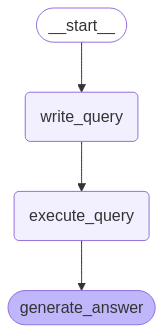

In [39]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [40]:
for step in graph.stream(
    {"question": "How many employees are in each department?"}, stream_mode="updates"
):
    print(step)



{'write_query': {'query': 'SELECT count(*) as employee_count, WORKDEPT FROM SAMPLE.EMPLOYEE GROUP BY WORKDEPT'}}
[{'EMPLOYEE_COUNT': 7, 'WORKDEPT': 'E11'}, {'EMPLOYEE_COUNT': 5, 'WORKDEPT': 'A00'}, {'EMPLOYEE_COUNT': 7, 'WORKDEPT': 'D21'}, {'EMPLOYEE_COUNT': 4, 'WORKDEPT': 'C01'}, {'EMPLOYEE_COUNT': 1, 'WORKDEPT': 'E01'}, {'EMPLOYEE_COUNT': 11, 'WORKDEPT': 'D11'}, {'EMPLOYEE_COUNT': 1, 'WORKDEPT': 'B01'}, {'EMPLOYEE_COUNT': 6, 'WORKDEPT': 'E21'}]
{'execute_query': {'result': "[(7, 'E11'), (5, 'A00'), (7, 'D21'), (4, 'C01'), (1, 'E01'), (11, 'D11'), (1, 'B01'), (6, 'E21')]"}}
{'generate_answer': {'answer': 'How many employees are in each department?\n\nThere are 7 employees in Department E11, 5 in A00, 7 in D21, 4 in C01, 1 in E01, 11 in D11, and 1 in B01. There are also 6 employees in E21.'}}
